In [1]:
# vivarium imports
from vivarium.core.process import Process
from vivarium.core.store import Store
from vivarium.core.composer import Composer
from vivarium.core.engine import Engine, pp
from vivarium.plots.topology import plot_topology

# Load the required components

## load sim_data

In [2]:
from ecoli.library.sim_data import LoadSimData

SIM_DATA_PATH = '../reconstruction/sim_data/kb/simData.cPickle'

load_sim_data = LoadSimData(
            sim_data_path=SIM_DATA_PATH,
            seed=0)

### load specific process parameters from sim_data

In [3]:
transcript_initiation_params = load_sim_data.get_transcript_initiation_config()
transcript_elongation_params = load_sim_data.get_transcript_elongation_config()

## get initial state snapshot

In [4]:
from ecoli.composites.ecoli_master import get_state_from_file

INITIAL_STATE_PATH = '../data/wcecoli_t0.json'

initial_state = get_state_from_file(path=INITIAL_STATE_PATH)

# Make processes by loading in parameters

In [5]:
from ecoli.processes.transcript_initiation import TranscriptInitiation
from ecoli.processes.transcript_elongation import TranscriptElongation

transcript_initiation = TranscriptInitiation(transcript_initiation_params)
transcript_elongation = TranscriptElongation(transcript_elongation_params)

## view a process' ports schema

In [6]:
pp(transcript_initiation.ports_schema())

{ 'RNAs': { '*': { 'RNAP_index': {'_default': 0, '_updater': 'set'},
                   'TU_index': {'_default': 0, '_updater': 'set'},
                   'can_translate': {'_default': 0, '_updater': 'set'},
                   'is_full_transcript': {'_default': 0, '_updater': 'set'},
                   'is_mRNA': {'_default': 0, '_updater': 'set'},
                   'transcript_length': { '_default': 0,
                                          '_emit': True,
                                          '_updater': 'set'},
                   'unique_index': {'_default': 0, '_updater': 'set'}}},
  'active_RNAPs': { '*': { 'coordinates': { '_default': 0,
                                            '_emit': True,
                                            '_updater': 'set'},
                           'direction': {'_default': 0, '_updater': 'set'},
                           'domain_index': {'_default': 0, '_updater': 'set'},
                           'unique_index': {'_default': 0, '_up

## run an individual process with minimal parameter set

In [7]:
import numpy as np
from vivarium.core.composition import simulate_process
from ecoli.processes.complexation import Complexation

# define parameters
test_config = {
    'stoichiometry': np.array([
        [-1, 1, 0],
        [0, -1, 1],
        [1, 0, -1],
        [-1, 0, 1],
        [1, -1, 0],
        [0, 1, -1]], np.int64),
    'rates': np.array([1, 1, 1, 1, 1, 1], np.float64),
    'molecule_names': ['A', 'B', 'C'],
    'seed': 1}

# define initial state
initial_complexation_state = {
    'molecules': {
        'A': 10,
        'B': 20,
        'C': 30}}

# initialize the process
complexation_process = Complexation(test_config)

# run simulation
settings = {
    'total_time': 10,
    'initial_state': initial_complexation_state}

# retrieve the data
data = simulate_process(complexation_process, settings)
pp(data)


Simulation ID: 8146243a-da85-11eb-a8c4-acde48001122
Created: 07/01/2021 at 09:00:49
Completed in 0.002147 seconds
{ 'molecules': { 'A': [10, 25, 18, 21, 18, 17, 19, 14, 28, 22, 33],
                 'B': [20, 14, 23, 15, 19, 20, 26, 21, 15, 17, 13],
                 'C': [30, 21, 19, 24, 23, 23, 15, 25, 17, 21, 14]},
  'time': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]}


# Compose a multiscale model

In [8]:
from ecoli.composites.ecoli_master import ECOLI_TOPOLOGY

# create an empty "cell" store
cell = Store({})

# generate a path and add a process in the leaf
cell.create(
    ['cytoplasm', 'transcript_initiation'], 
    transcript_initiation, 
    topology=ECOLI_TOPOLOGY['transcript_initiation'])

cell.create(
    ['cytoplasm', 'transcript_elongation'], 
    transcript_elongation, 
    topology=ECOLI_TOPOLOGY['transcript_elongation'])

In [9]:
pp(cell.get_value())

{ 'cytoplasm': { 'transcript_elongation': <ecoli.processes.transcript_elongation.TranscriptElongation object at 0x12e1f0730>,
                 'transcript_initiation': <ecoli.processes.transcript_initiation.TranscriptInitiation object at 0x12e1f08e0>}}


## put the model in an Engine

In [16]:
# cell_experiment = Engine({'store': cell})

## run the simulation

In [ ]:
# total_time = 10
# cell_experiment.update(total_time)

## retrieve the data

In [ ]:
# # in "data" format with keys for each time step and emitted states as values
# data = cell_experiment.emitter.get_data()

# # in "timeseries" format with keys for the states, and a timeseries list as values
# timeseries = cell_experiment.emitter.get_data()

# Ecoli master composite

## load the composer

In [11]:
from ecoli.composites.ecoli_master import Ecoli

ecoli_config = {
    'agent_id': '1',
    '_schema': {
        'equilibrium': {
            'molecules': {
                'PD00413[c]': {
                    '_updater': 'nonnegative_accumulate'
                }
            }
        }
    },
    'sim_data_path': SIM_DATA_PATH}
ecoli_composer = Ecoli(ecoli_config)

## plot topology

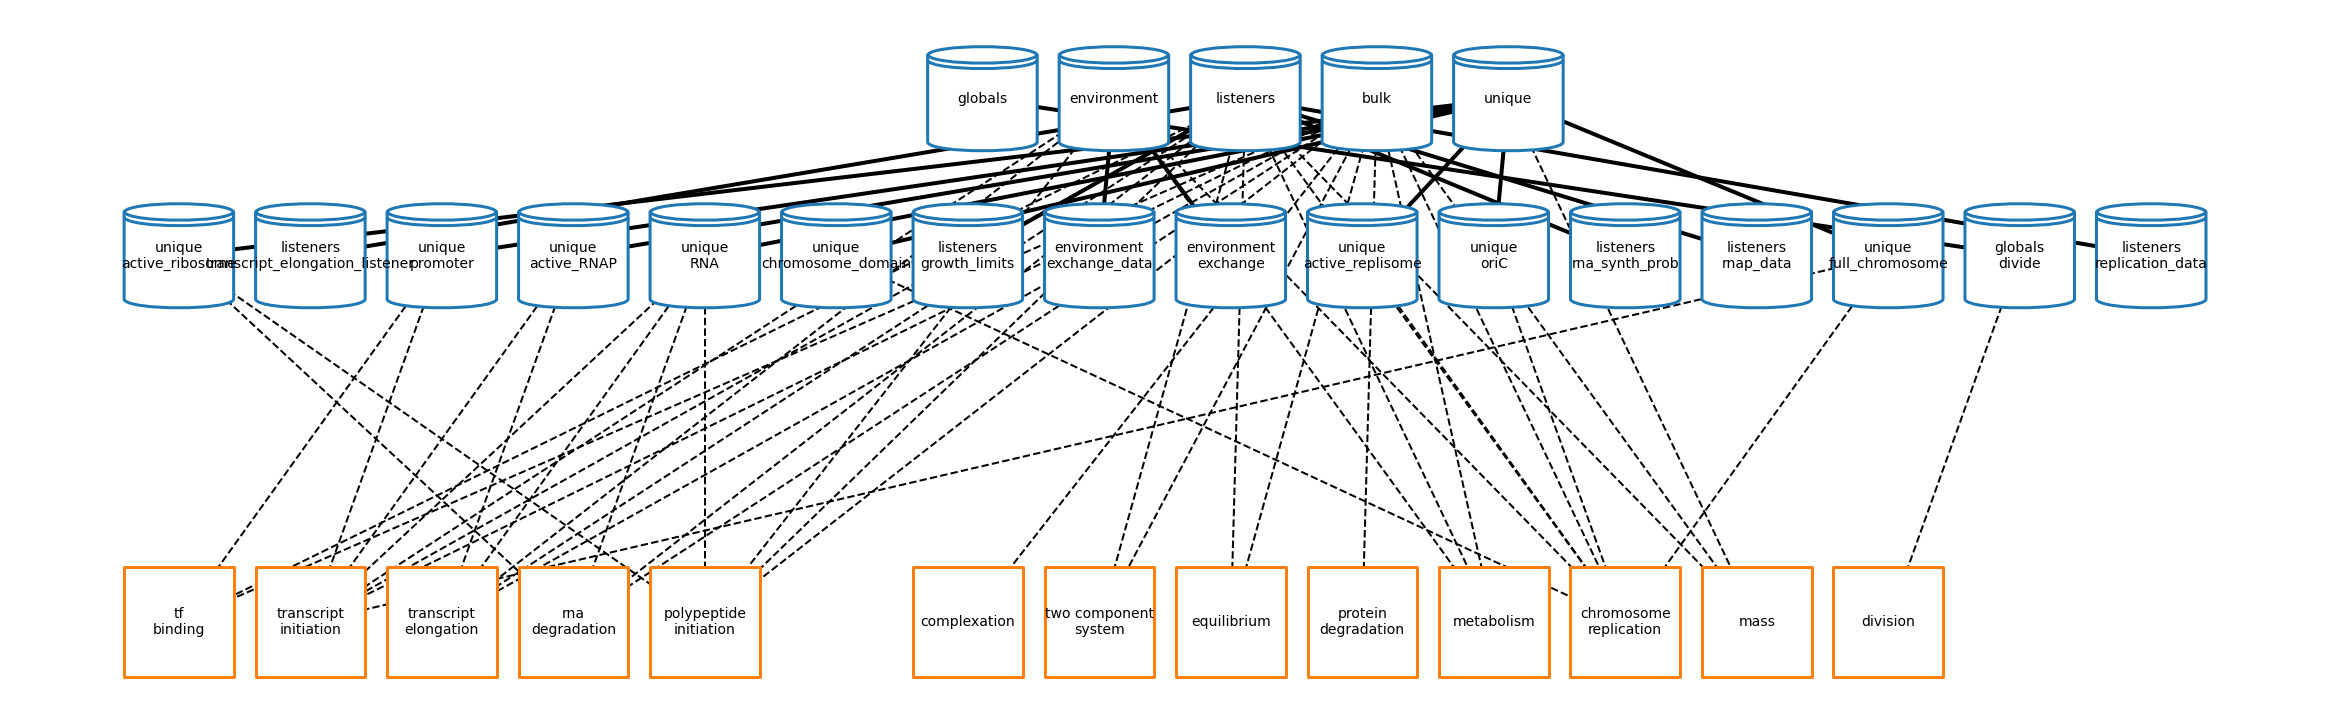

In [12]:
from ecoli.composites.ecoli_master import ecoli_topology_plot
topology_plot = ecoli_topology_plot(config=ecoli_config)

# initialize the simulation

In [13]:
ecoli = ecoli_composer.generate()
ecoli_simulation = Engine({
    'processes': ecoli.processes,
    'topology': ecoli.topology,
    'initial_state': initial_state,
    'progress_bar': True,
})


Simulation ID: 9318e530-da85-11eb-a8c4-acde48001122
Created: 07/01/2021 at 09:01:22


/Users/eranagmon/.pyenv/versions/3.8.3/envs/vivarium_ecoli/lib/python3.8/site-packages/vivarium/core/engine.py:362: UserWarning: configuration size is too big for the emitter, discarding process parameters
  warnings.warn('configuration size is too big for the emitter, '


## run the simulation

In [14]:
total_time = 10
ecoli_simulation.update(total_time)

Progress:|██████████████████████████████████████████████████| 0.0/10.0 simulated seconds remaining    
Completed in 14.30 seconds


## examine output

In [15]:
# retrieve the data
output = ecoli_simulation.emitter.get_timeseries()

# separate data by port
bulk = output['bulk']
unique = output['unique']
listeners = output['listeners']
process_state = output['process_state']
environment = output['environment']

pp(listeners['mass'])

{ 'cell_mass': [ 1166.0094499617767,
                 1166.007471829658,
                 1166.1865145295214,
                 1166.1845368600557,
                 1166.3474760900094,
                 1166.345498469762,
                 1166.522793692658,
                 1166.5208160379577,
                 1166.7307031521998,
                 1166.7287254909368,
                 1166.9800050762349],
  'dry_mass': [ 346.6085586338562,
                346.60658050173754,
                346.6230112635001,
                346.6210335940343,
                346.6641769510833,
                346.66219933083596,
                346.7267366914265,
                346.72475903672614,
                346.79822849352865,
                346.7962508322656,
                346.8747023106449],
  'water_mass': [ 819.4008913279205,
                  819.4008913279205,
                  819.5635032660214,
                  819.5635032660214,
                  819.6832991389261,
                  81